In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *

sampling_indices = (3, 4)

## Generate many objects in parallel

2023-11-20 17:39:21.459388: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


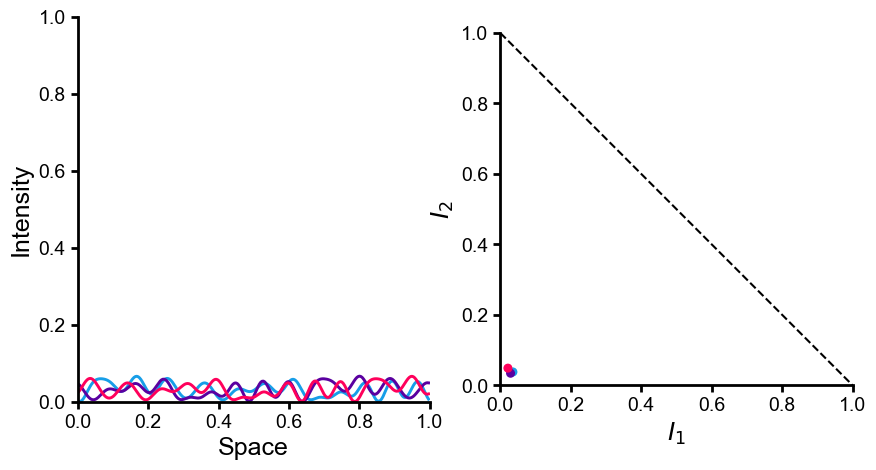

In [2]:
n_objects = 20
objects = np.array([sample_amplitude_object('delta') for i in range(n_objects)])

# generate random convolution kernel
random_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
conv_mat = make_convolutional_encoder(random_kernel)

output_signals = objects @ conv_mat.T 


sampling_indices = (3, 4)
num_to_plot = 3

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], output_signals[:num_to_plot], sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], output_signals[:num_to_plot], sample_point_indices=sampling_indices, differentiate_colors=True)

## Show example objects

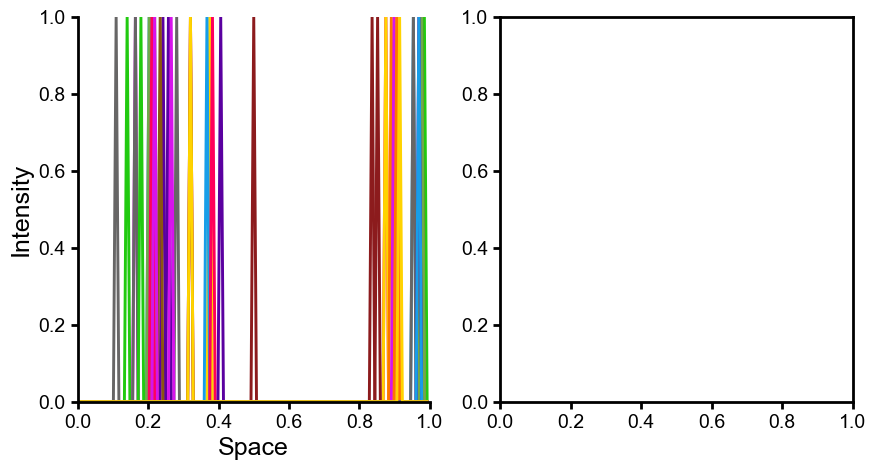

In [9]:
n_objects = 40
objects = np.array([sample_amplitude_object('delta', gaussian_mixture_position=True) for i in range(n_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(n_objects)])

# plot all the objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], objects, sample_point_indices=sampling_indices, plot_lim=1)



## Optimize an encoder based on entropy as a loss function

In [3]:
N_objects = 2000
noise_sigma = 0.01
N_objects_to_plot = 1
N_signals_to_plot = 6
# erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)

erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)
# non_erased_indices = onp.random.choice(erasure_mask.size, int(erasure_mask.size * 0.25), replace=False)

erasure_mask = np.array(erasure_mask, dtype=bool)
sampling_indices = (1, 2)

objects = np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta', num_deltas=5) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('pink_noise') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('white_noise') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('random_amplitude_delta') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('random_pairs') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta_in_some_places') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(N_objects)])


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
# initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.5)

initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))

loss_fn = make_convolutional_forward_model_with_mi_loss_and_erasure(objects, erasure_mask, noise_sigma=noise_sigma)
optimized_params = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                         initial_params,
                           learning_rate=1e-2, learning_rate_decay=0.999,
                           verbose=True,
                         loss_improvement_patience=2000, max_epochs=5000, key=jax.random.PRNGKey(0))
optimized_loss = loss_fn(optimized_params, jax.random.PRNGKey(1))


initial loss -0.5778779340876007


Text(0.5, 0.98, 'Best loss: -1.8957')

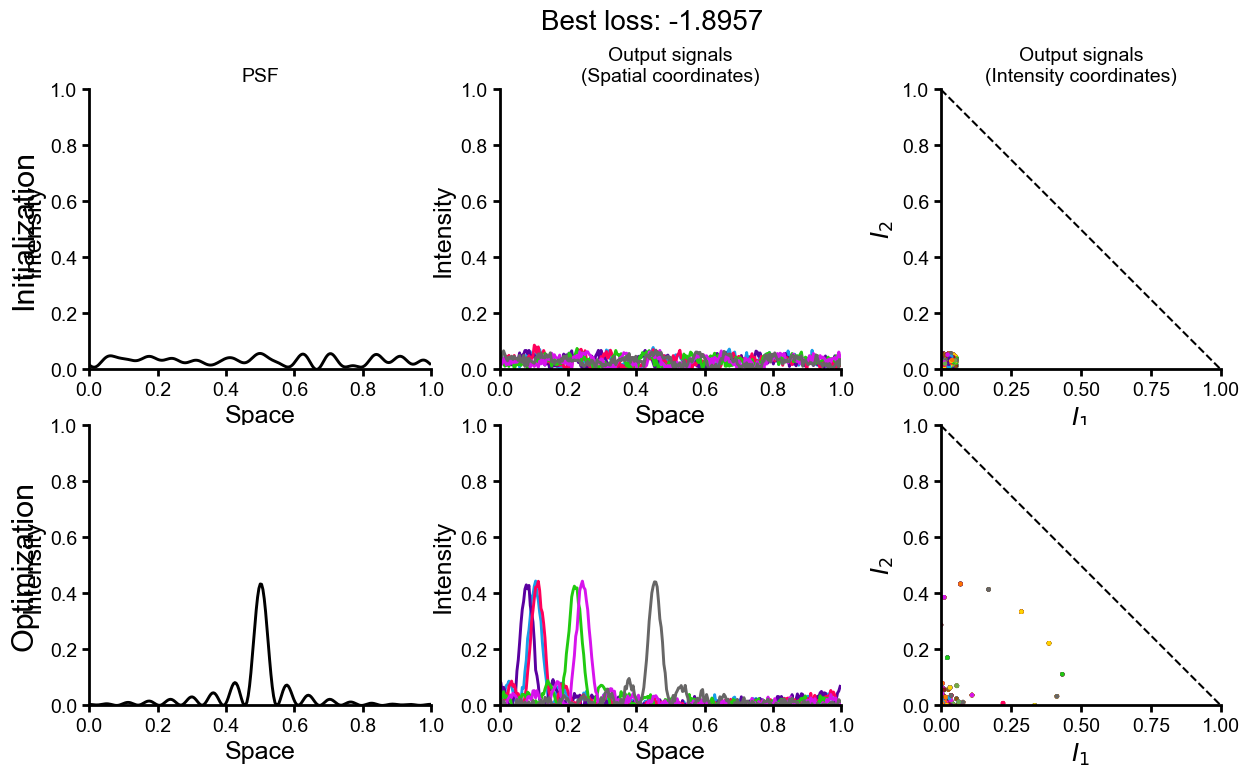

In [17]:
# plot the initial and optimized convolutional encoders
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

plot_in_spatial_coordinates(ax[0, 0], initial_kernel, show_samples=False, center=True)
plot_in_spatial_coordinates(ax[1, 0], signal_from_real_imag_param_vec(optimized_params), show_samples=False, center=True)
ax[0,0].set_title('PSF')


ax[0, 0].text(-0.15, 0.5, 'Initialization', transform=ax[0, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)           
ax[1, 0].text(-0.15, 0.5, 'Optimization', transform=ax[1, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)       

noise_sigma = 0.01
def make_noisy_output_signals(params, objects, erasure_mask, noise_sigma):
    return add_gaussian_noise_numpy(upsample_signal(conv_forward_model_with_erasure(params, objects, erasure_mask)), noise_sigma)

# plot the output signals
plot_in_spatial_coordinates(ax[0, 1], make_noisy_output_signals(initial_params, objects[:N_signals_to_plot], erasure_mask, noise_sigma), show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], make_noisy_output_signals(optimized_params, objects[:N_signals_to_plot], erasure_mask, noise_sigma), show_samples=False)
ax[0,1].set_title('Output signals\n(Spatial coordinates)')

# plot the output signals in intensity coordinates
plot_in_intensity_coordinates(ax[0, 2], conv_forward_model_with_erasure(initial_params, objects, erasure_mask),
                               markersize=5, differentiate_colors=True, sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1, 2], conv_forward_model_with_erasure(optimized_params, objects, erasure_mask),
                               markersize=5, differentiate_colors=True, sample_point_indices=sampling_indices)
ax[0,2].set_title('Output signals\n(Intensity coordinates)')
fig.suptitle(f'Best loss: {optimized_loss:.4f}', fontsize=20)


## Erasure and the optimal PSF
Run a bunch of optimizations with different initializations and find the best PSFs with and without erasure of the measurement pixels

In [23]:
from signal_utils_1D import *
import cmcrameri # required in order to register the colormaps with Matplotlib
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

N_objects = 2000
num_loops = 4
noise_sigma = 0.01


objects = np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=True) for i in range(N_objects)])
test_objects = np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=True) for i in range(N_objects)])


### erase sensor pixels
# optimize with same init
erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
# erasure_mask[int(0.1 * erasure_mask.size): int(0.2 * erasure_mask.size)] = 1
# erasure_mask[int(0.3 * erasure_mask.size): int(0.4 * erasure_mask.size)] = 1
# erasure_mask[int(0.45 * erasure_mask.size): int(0.55 * erasure_mask.size)] = 1
# erasure_mask[int(0.7 * erasure_mask.size): int(0.8 * erasure_mask.size)] = 1
# erasure_mask[int(0.9 * erasure_mask.size): int(erasure_mask.size)] = 1
# erasure_mask = np.array(erasure_mask, dtype=bool)

# make an erasur mask with 90% of the pixels erased
onp.random.seed(123)
erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
non_erased_indices = onp.random.choice(erasure_mask.size, int(erasure_mask.size * 0.25), replace=False)
erasure_mask[non_erased_indices] = 1
erasure_mask = np.array(erasure_mask, dtype=bool)

non_erasure_mask = np.ones(erasure_mask.size, dtype=bool)


# sampling indices are two random non-erased indices
sampling_indices = onp.random.choice(non_erased_indices, 2, replace=False)


decay = 0.999

best_erasure_mi = -np.inf
best_no_erasure_mi = -np.inf

for _ in tqdm(range(num_loops)):
  # if condition_index == 0:
  #   print('initializing with random kernel')
  #   initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
  # elif condition_index == 1:
  #   print('initializing with nearly uniform kernel')
  #   initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.01)
  # else:
    # print('initializing with moderately nonuniform kernel')
  initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.5)

  initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))



  loss_fn = make_convolutional_forward_model_with_mi_loss_and_erasure(objects, non_erasure_mask)
  optimized_params_no_erasure = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                          initial_params,
                            learning_rate=1e-2, learning_rate_decay=decay,
                            verbose=True,
                          loss_improvement_patience=2000, max_epochs=5000, key=jax.random.PRNGKey(12))
  optimized_kernel_no_erasure = signal_from_real_imag_param_vec(optimized_params_no_erasure)


  loss_fn = make_convolutional_forward_model_with_mi_loss_and_erasure(objects, erasure_mask)
  optimized_params_with_erasure = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                          initial_params,
                            learning_rate=1e-2, learning_rate_decay=decay,
                            verbose=True,
                          loss_improvement_patience=2000, max_epochs=5000, key=jax.random.PRNGKey(12))
  optimized_kernel_with_erasure = signal_from_real_imag_param_vec(optimized_params_with_erasure)


  ## shift the  kernels to be centered for beter visualization
  initial_kernel = np.roll(initial_kernel, initial_kernel.size // 2 - np.argmax(initial_kernel))
  optimized_kernel_no_erasure = np.roll(optimized_kernel_no_erasure, optimized_kernel_no_erasure.size // 2 - np.argmax(optimized_kernel_no_erasure))
  optimized_kernel_with_erasure = np.roll(optimized_kernel_with_erasure, optimized_kernel_with_erasure.size // 2 - np.argmax(optimized_kernel_with_erasure))

  initial_params_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(initial_kernel)))
  optimized_params_no_erasure_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(optimized_kernel_no_erasure)))
  optimized_params_with_erasure_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(optimized_kernel_with_erasure)))
  
  # compute signals with optimized kernels
  initial_signals = conv_forward_model_with_erasure(initial_params_for_display, test_objects, erasure_mask, align_center=False)
  optimized_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, test_objects, erasure_mask, align_center=False)
  optimized_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, test_objects, erasure_mask, align_center=False)

  # add noise 
  initial_signals = add_gaussian_noise_numpy(initial_signals, noise_sigma)
  optimized_signals_no_erasure = add_gaussian_noise_numpy(optimized_signals_no_erasure, noise_sigma)
  optimized_signals_with_erasure = add_gaussian_noise_numpy(optimized_signals_with_erasure, noise_sigma)

  initial_mi = compute_mutual_information_per_pixel(initial_signals[:, erasure_mask], noise_sigma)
  optimized_mi_no_erasure = compute_mutual_information_per_pixel(optimized_signals_no_erasure[:, erasure_mask], noise_sigma)
  optimized_mi_with_erasure = compute_mutual_information_per_pixel(optimized_signals_with_erasure[:, erasure_mask], noise_sigma)

  print(f'Optimized entropy without erasure: {optimized_mi_no_erasure:.4f}')
  print(f'Optimized entropy with erasure: {optimized_mi_with_erasure:.4f}')

  if optimized_mi_no_erasure > best_no_erasure_mi:
    best_no_erasure_mi = optimized_mi_no_erasure
    best_no_erasure_params = optimized_params_no_erasure
    best_no_erasure_kernel = optimized_kernel_no_erasure
  if optimized_mi_with_erasure > best_erasure_mi:
    best_erasure_mi = optimized_mi_with_erasure
    best_erasure_params = optimized_params_with_erasure
    best_erasure_kernel = optimized_kernel_with_erasure



  0%|          | 0/4 [00:00<?, ?it/s]

initial loss -inf


  0%|          | 0/4 [00:02<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 0.98, 'Initial: -91.86, Optimized (no erasure): -46.42, Optimized (with erasure): -43.17')

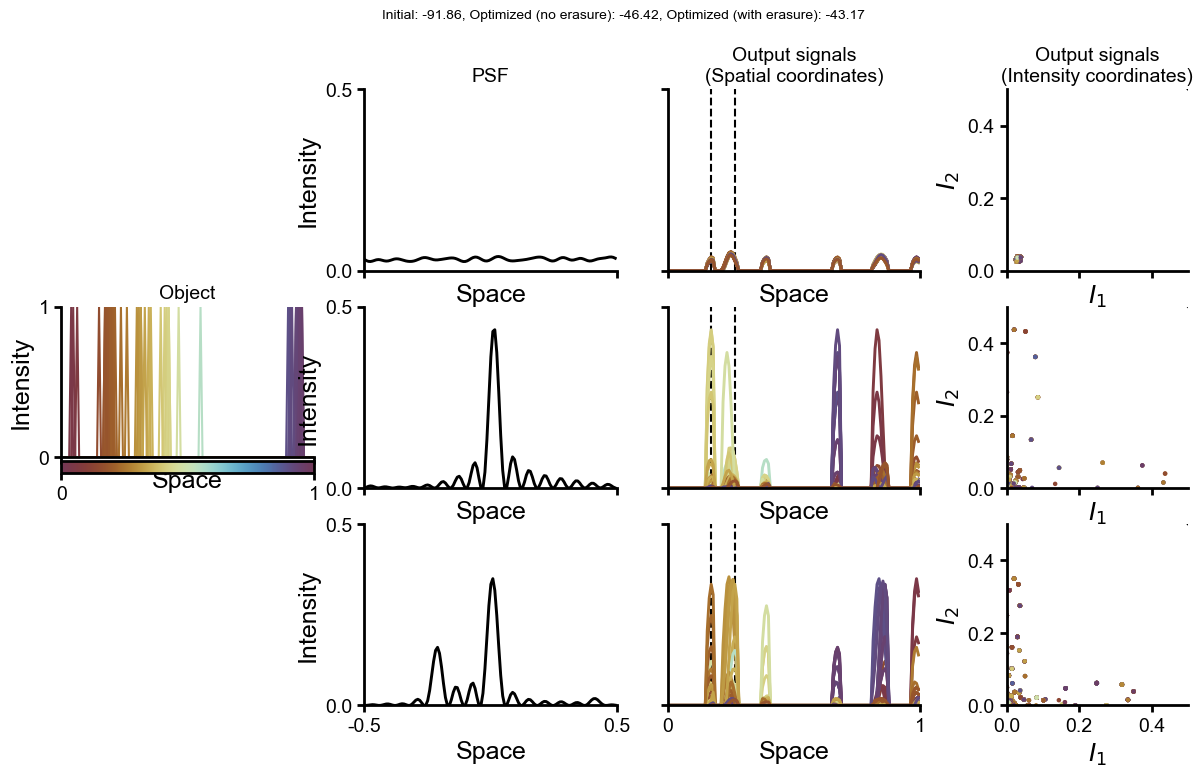

In [7]:
N_signals_to_plot = 40
example_objects = test_objects[:N_signals_to_plot]


optimized_params_with_erasure = best_erasure_params
optimized_kernel_with_erasure = best_erasure_kernel
optimized_params_no_erasure = best_no_erasure_params
optimized_kernel_no_erasure = best_no_erasure_kernel

########################## Plot the results #####################################

fig, ax = plt.subplots(3, 4, figsize=(15, 8), sharex='col')

### plot delta function objects, colored by position
colormap = plt.get_cmap('cmc.romaO')
object_colors = [colormap((np.argmax(o) + 0.5) / o.size) for o in objects]
example_object_colors = [colormap((np.argmax(o) + 0.5) / o.size) for o in example_objects]
plot_object(ax[1, 0], example_objects[:N_signals_to_plot], colors=example_object_colors[:N_signals_to_plot])
ax[0,0].axis('off')
ax[1, 0].set_title('Object')
ax[2, 0].axis('off')

# show a color bar on the x axis
x_positions = np.linspace(0, 1, 100)
colors = colormap(x_positions) 
norm = Normalize(vmin=min(x_positions), vmax=max(x_positions))
scalar_mappable = ScalarMappable(norm=norm, cmap=colormap)
cbar = fig.colorbar(scalar_mappable, ax=ax[1, 0], orientation='horizontal', pad=0.02)
# set the tick labels of the colorbar
cbar.set_ticks([0, 1])


# plot the output signals
initial_example_signals = conv_forward_model_with_erasure(initial_params_for_display, example_objects, erasure_mask, align_center=False)
optimized_example_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, example_objects, erasure_mask, align_center=False)
optimized_example_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, example_objects, erasure_mask, align_center=False)


intensity_lim_max = max(optimized_example_signals_no_erasure.max(), optimized_example_signals_with_erasure.max()) * 1.1
# ceil to the nearest .1
intensity_lim_max = np.ceil(intensity_lim_max * 10) / 10

plot_in_spatial_coordinates(ax[0, 1], initial_kernel, show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], optimized_kernel_no_erasure, show_samples=False)
plot_in_spatial_coordinates(ax[2, 1], optimized_kernel_with_erasure, show_samples=False)
ax[0, 1].set_title('PSF')
for a in ax[:, 1]:
    a.set(yticks=[0, intensity_lim_max], ylim=[0, intensity_lim_max], xticks=[0,1], xticklabels=[-0.5, 0.5])



plot_in_spatial_coordinates(ax[0, 2], initial_example_signals, show_samples=False, 
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)
plot_in_spatial_coordinates(ax[1, 2], optimized_example_signals_no_erasure, show_samples=False,
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)
plot_in_spatial_coordinates(ax[2, 2], optimized_example_signals_with_erasure, show_samples=False,
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)

ax[0, 2].set_title('Output signals\n(Spatial coordinates)')
for a in ax[:, 2]:
    a.set(ylabel=None, yticks=[0, intensity_lim_max], yticklabels=[], ylim=[0, intensity_lim_max], xticks=[0, 1])


# plot all output signals in intensity coordinates
initial_signals = conv_forward_model_with_erasure(initial_params_for_display, test_objects, erasure_mask, align_center=False)
optimized_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, test_objects, erasure_mask, align_center=False)
optimized_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, test_objects, erasure_mask, align_center=False)


plot_in_intensity_coordinates(ax[0, 3], initial_signals, markersize=5, color = object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)
plot_in_intensity_coordinates(ax[1, 3], optimized_signals_no_erasure, markersize=5, color=object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)                            
plot_in_intensity_coordinates(ax[2, 3], optimized_signals_with_erasure, markersize=5, color=object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)
ax[0, 3].set_title('Output signals\n(Intensity coordinates)')



initial_entropy = calc_log_sum_evs(initial_signals[:, erasure_mask])
optimized_entropy_no_erasure = calc_log_sum_evs(optimized_signals_no_erasure[:, erasure_mask])
optimized_entropy_with_erasure = calc_log_sum_evs(optimized_signals_with_erasure[:, erasure_mask])

# add suptitle
fig.suptitle(f'Initial: {initial_entropy:.2f}, Optimized (no erasure): {optimized_entropy_no_erasure:.2f}, Optimized (with erasure): {optimized_entropy_with_erasure:.2f}', fontsize=10)



### Initialize with best non-erasure params and see that it changes

initial loss 284.15136971267026
initial loss 48.284127493703


Text(0.5, 0.98, 'Initial: -46.52, Optimized (no erasure): -46.42, Optimized (with erasure): -42.32')

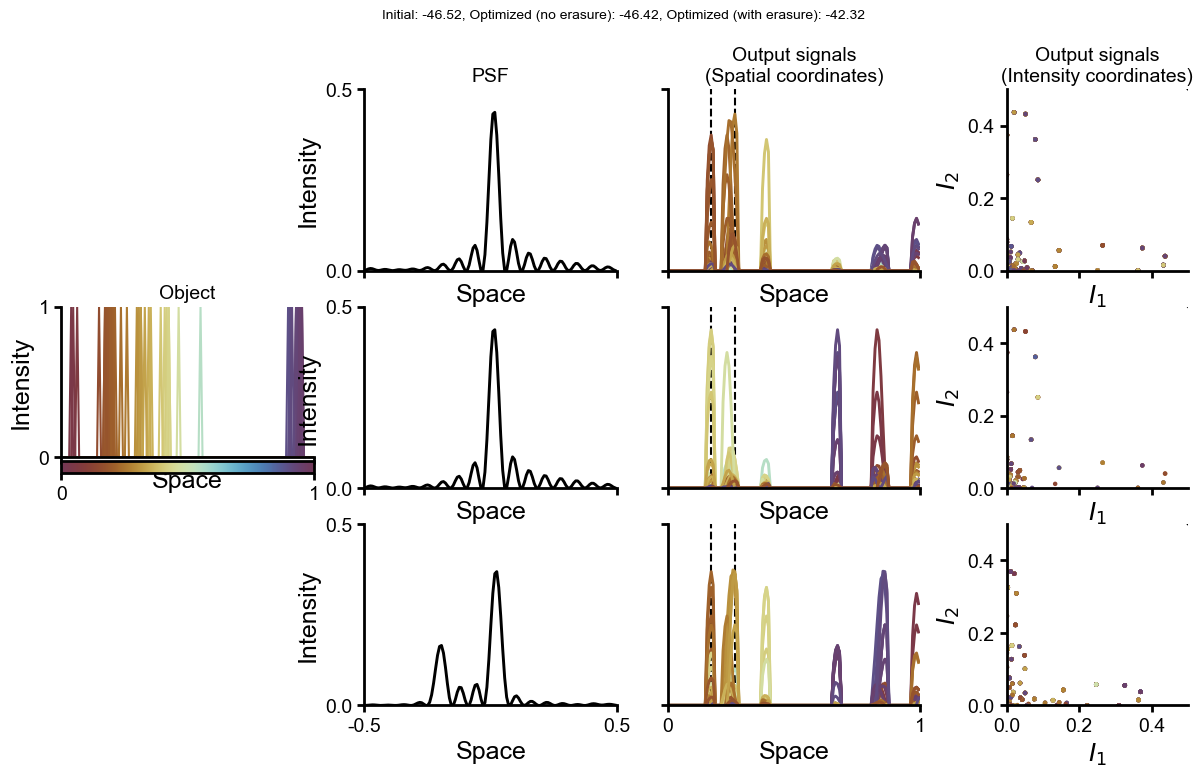

In [8]:
decay = 0.999

initial_params = best_no_erasure_params
initial_kernel = best_no_erasure_kernel


loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, non_erasure_mask)
optimized_params_no_erasure = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                        initial_params,
                        learning_rate=1e-4, learning_rate_decay=decay,
                        verbose=True,
                        loss_improvement_patience=2000, max_epochs=5000)
optimized_kernel_no_erasure = signal_from_real_imag_param_vec(optimized_params_no_erasure)




loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, erasure_mask)
optimized_params_with_erasure = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                        initial_params,
                        learning_rate=1e-4, learning_rate_decay=decay,
                        verbose=True,
                        loss_improvement_patience=2000, max_epochs=5000)
optimized_kernel_with_erasure = signal_from_real_imag_param_vec(optimized_params_with_erasure)


## shift the  kernels to be centered for beter visualization
initial_kernel = np.roll(initial_kernel, initial_kernel.size // 2 - np.argmax(initial_kernel))
optimized_kernel_no_erasure = np.roll(optimized_kernel_no_erasure, optimized_kernel_no_erasure.size // 2 - np.argmax(optimized_kernel_no_erasure))
optimized_kernel_with_erasure = np.roll(optimized_kernel_with_erasure, optimized_kernel_with_erasure.size // 2 - np.argmax(optimized_kernel_with_erasure))

initial_params_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(initial_kernel)))
optimized_params_no_erasure_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(optimized_kernel_no_erasure)))
optimized_params_with_erasure_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(optimized_kernel_with_erasure)))

# compute signals with optimized kernels
initial_signals = conv_forward_model_with_erasure(initial_params_for_display, test_objects, erasure_mask, align_center=False)
optimized_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, test_objects, erasure_mask, align_center=False)
optimized_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, test_objects, erasure_mask, align_center=False)

initial_entropy = calc_log_sum_evs(initial_signals[:, erasure_mask])
optimized_entropy_no_erasure = calc_log_sum_evs(optimized_signals_no_erasure[:, erasure_mask])
optimized_entropy_with_erasure = calc_log_sum_evs(optimized_signals_with_erasure[:, erasure_mask])


########################## Plot the results #####################################

fig, ax = plt.subplots(3, 4, figsize=(15, 8), sharex='col')

### plot delta function objects, colored by position
colormap = plt.get_cmap('cmc.romaO')
object_colors = [colormap((np.argmax(o) + 0.5) / o.size) for o in objects]
example_object_colors = [colormap((np.argmax(o) + 0.5) / o.size) for o in example_objects]
plot_object(ax[1, 0], example_objects[:N_signals_to_plot], colors=example_object_colors[:N_signals_to_plot])
ax[0,0].axis('off')
ax[1, 0].set_title('Object')
ax[2, 0].axis('off')

# show a color bar on the x axis
x_positions = np.linspace(0, 1, 100)
colors = colormap(x_positions) 
norm = Normalize(vmin=min(x_positions), vmax=max(x_positions))
scalar_mappable = ScalarMappable(norm=norm, cmap=colormap)
cbar = fig.colorbar(scalar_mappable, ax=ax[1, 0], orientation='horizontal', pad=0.02)
# set the tick labels of the colorbar
cbar.set_ticks([0, 1])


# plot the output signals
initial_example_signals = conv_forward_model_with_erasure(initial_params_for_display, example_objects, erasure_mask, align_center=False)
optimized_example_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, example_objects, erasure_mask, align_center=False)
optimized_example_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, example_objects, erasure_mask, align_center=False)


intensity_lim_max = max(optimized_example_signals_no_erasure.max(), optimized_example_signals_with_erasure.max())
# ceil to the nearest .1
intensity_lim_max = np.ceil(intensity_lim_max * 10) / 10

plot_in_spatial_coordinates(ax[0, 1], initial_kernel, show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], optimized_kernel_no_erasure, show_samples=False)
plot_in_spatial_coordinates(ax[2, 1], optimized_kernel_with_erasure, show_samples=False)
ax[0, 1].set_title('PSF')
for a in ax[:, 1]:
    a.set(yticks=[0, intensity_lim_max], ylim=[0, intensity_lim_max], xticks=[0,1], xticklabels=[-0.5, 0.5])



plot_in_spatial_coordinates(ax[0, 2], initial_example_signals, show_samples=False, 
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)
plot_in_spatial_coordinates(ax[1, 2], optimized_example_signals_no_erasure, show_samples=False,
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)
plot_in_spatial_coordinates(ax[2, 2], optimized_example_signals_with_erasure, show_samples=False,
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)

ax[0, 2].set_title('Output signals\n(Spatial coordinates)')
for a in ax[:, 2]:
    a.set(ylabel=None, yticks=[0, intensity_lim_max], yticklabels=[], ylim=[0, intensity_lim_max], xticks=[0, 1])


# plot all output signals in intensity coordinates
initial_signals = conv_forward_model_with_erasure(initial_params_for_display, test_objects, erasure_mask, align_center=False)
optimized_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, test_objects, erasure_mask, align_center=False)
optimized_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, test_objects, erasure_mask, align_center=False)


plot_in_intensity_coordinates(ax[0, 3], initial_signals, markersize=5, color = object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)
plot_in_intensity_coordinates(ax[1, 3], optimized_signals_no_erasure, markersize=5, color=object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)                            
plot_in_intensity_coordinates(ax[2, 3], optimized_signals_with_erasure, markersize=5, color=object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)
ax[0, 3].set_title('Output signals\n(Intensity coordinates)')



initial_entropy = calc_log_sum_evs(initial_signals[:, erasure_mask])
optimized_entropy_no_erasure = calc_log_sum_evs(optimized_signals_no_erasure[:, erasure_mask])
optimized_entropy_with_erasure = calc_log_sum_evs(optimized_signals_with_erasure[:, erasure_mask])

# add suptitle
fig.suptitle(f'Initial: {initial_entropy:.2f}, Optimized (no erasure): {optimized_entropy_no_erasure:.2f}, Optimized (with erasure): {optimized_entropy_with_erasure:.2f}', fontsize=10)



# Compare to uniformly located delta functions

In [9]:
from signal_utils_1D import *
import cmcrameri # required in order to register the colormaps with Matplotlib
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def calc_log_sum_evs(output_signals):
    mean_subtracted = output_signals.T - np.mean(output_signals.T, axis=1, keepdims=True)
    cov_mat = np.cov(mean_subtracted)
    eig_vals = np.linalg.eigvalsh(cov_mat)
    log_evs = np.log(eig_vals)
    # print log_evs in 2 decimal places
    # print(np.round(log_evs, 2))
    return np.sum(log_evs)


N_objects = 2000
num_loops = 4


objects = np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=False) for i in range(N_objects)])
test_objects = np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=False) for i in range(N_objects)])


### erase sensor pixels
# optimize with same init
erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
# erasure_mask[int(0.1 * erasure_mask.size): int(0.2 * erasure_mask.size)] = 1
# erasure_mask[int(0.3 * erasure_mask.size): int(0.4 * erasure_mask.size)] = 1
# erasure_mask[int(0.45 * erasure_mask.size): int(0.55 * erasure_mask.size)] = 1
# erasure_mask[int(0.7 * erasure_mask.size): int(0.8 * erasure_mask.size)] = 1
# erasure_mask[int(0.9 * erasure_mask.size): int(erasure_mask.size)] = 1
# erasure_mask = np.array(erasure_mask, dtype=bool)

# make an erasur mask with 90% of the pixels erased
onp.random.seed(123)
erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
non_erased_indices = onp.random.choice(erasure_mask.size, int(erasure_mask.size * 0.25), replace=False)
erasure_mask[non_erased_indices] = 1
erasure_mask = np.array(erasure_mask, dtype=bool)

non_erasure_mask = np.ones(erasure_mask.size, dtype=bool)


# sampling indices are two random non-erased indices
sampling_indices = onp.random.choice(non_erased_indices, 2, replace=False)


decay = 0.999

best_erasure_entropy = -np.inf
best_no_erasure_entropy = -np.inf

for _ in tqdm(range(num_loops)):
  # if condition_index == 0:
  #   print('initializing with random kernel')
  #   initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
  # elif condition_index == 1:
  #   print('initializing with nearly uniform kernel')
  #   initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.01)
  # else:
    # print('initializing with moderately nonuniform kernel')
  initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.5)

  initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))



  loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, non_erasure_mask)
  optimized_params_no_erasure = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                          initial_params,
                            learning_rate=1e-4, learning_rate_decay=decay,
                            verbose=True,
                          loss_improvement_patience=2000, max_epochs=5000)
  optimized_kernel_no_erasure = signal_from_real_imag_param_vec(optimized_params_no_erasure)



  loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, erasure_mask)
  optimized_params_with_erasure = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                          initial_params,
                            learning_rate=1e-4, learning_rate_decay=decay,
                            verbose=True,
                          loss_improvement_patience=2000, max_epochs=5000)
  optimized_kernel_with_erasure = signal_from_real_imag_param_vec(optimized_params_with_erasure)


  ## shift the  kernels to be centered for beter visualization
  initial_kernel = np.roll(initial_kernel, initial_kernel.size // 2 - np.argmax(initial_kernel))
  optimized_kernel_no_erasure = np.roll(optimized_kernel_no_erasure, optimized_kernel_no_erasure.size // 2 - np.argmax(optimized_kernel_no_erasure))
  optimized_kernel_with_erasure = np.roll(optimized_kernel_with_erasure, optimized_kernel_with_erasure.size // 2 - np.argmax(optimized_kernel_with_erasure))

  initial_params_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(initial_kernel)))
  optimized_params_no_erasure_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(optimized_kernel_no_erasure)))
  optimized_params_with_erasure_for_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(optimized_kernel_with_erasure)))
  
  # compute signals with optimized kernels
  initial_signals = conv_forward_model_with_erasure(initial_params_for_display, test_objects, erasure_mask, align_center=False)
  optimized_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, test_objects, erasure_mask, align_center=False)
  optimized_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, test_objects, erasure_mask, align_center=False)

  initial_entropy = calc_log_sum_evs(initial_signals[:, erasure_mask])
  optimized_entropy_no_erasure = calc_log_sum_evs(optimized_signals_no_erasure[:, erasure_mask])
  optimized_entropy_with_erasure = calc_log_sum_evs(optimized_signals_with_erasure[:, erasure_mask])
  print('optimized_entropy_no_erasure', optimized_entropy_no_erasure)
  print('optimized_entropy_with_erasure', optimized_entropy_with_erasure)

  if optimized_entropy_with_erasure > best_erasure_entropy:
    best_erasure_entropy = optimized_entropy_with_erasure
    best_erasure_params = optimized_params_with_erasure
    best_erasure_kernel = optimized_kernel_with_erasure
  if optimized_entropy_no_erasure > best_no_erasure_entropy:
    best_no_erasure_entropy = optimized_entropy_no_erasure
    best_no_erasure_params = optimized_params_no_erasure
    best_no_erasure_kernel = optimized_kernel_no_erasure
  



  0%|          | 0/4 [00:00<?, ?it/s]

initial loss 393.4370276111547
initial loss 93.9018852970956


 25%|██▌       | 1/4 [01:11<03:34, 71.56s/it]

optimized_entropy_no_erasure -41.530650878309075
optimized_entropy_with_erasure -38.31938628827157
initial loss 393.1068303671627
initial loss 92.54661430062042


 50%|█████     | 2/4 [02:22<02:22, 71.20s/it]

optimized_entropy_no_erasure -41.63369717622781
optimized_entropy_with_erasure -46.66866954751827
initial loss 400.19925055143847
initial loss 93.14604663861297


 75%|███████▌  | 3/4 [03:37<01:12, 72.74s/it]

optimized_entropy_no_erasure -47.58450736225526
optimized_entropy_with_erasure -38.90418922639584
initial loss 380.0860424765476
initial loss 90.49700661332209


100%|██████████| 4/4 [04:50<00:00, 72.53s/it]

optimized_entropy_no_erasure -50.81670545242393
optimized_entropy_with_erasure -38.62038411583033


Text(0.5, 0.98, 'Initial: -90.41, Optimized (no erasure): -41.53, Optimized (with erasure): -38.32')

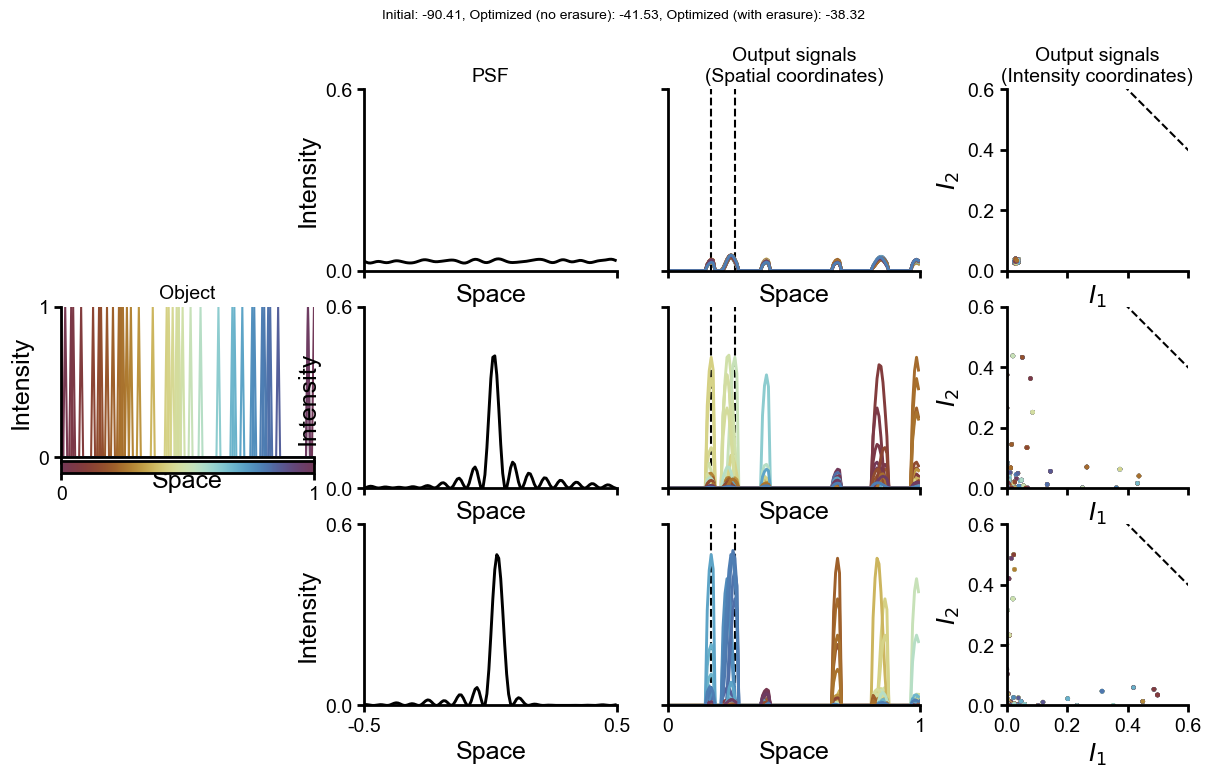

In [10]:
N_signals_to_plot = 40
example_objects = test_objects[:N_signals_to_plot]


optimized_params_with_erasure = best_erasure_params
optimized_kernel_with_erasure = best_erasure_kernel
optimized_params_no_erasure = best_no_erasure_params
optimized_kernel_no_erasure = best_no_erasure_kernel

########################## Plot the results #####################################

fig, ax = plt.subplots(3, 4, figsize=(15, 8), sharex='col')

### plot delta function objects, colored by position
colormap = plt.get_cmap('cmc.romaO')
object_colors = [colormap((np.argmax(o) + 0.5) / o.size) for o in objects]
example_object_colors = [colormap((np.argmax(o) + 0.5) / o.size) for o in example_objects]
plot_object(ax[1, 0], example_objects[:N_signals_to_plot], colors=example_object_colors[:N_signals_to_plot])
ax[0,0].axis('off')
ax[1, 0].set_title('Object')
ax[2, 0].axis('off')

# show a color bar on the x axis
x_positions = np.linspace(0, 1, 100)
colors = colormap(x_positions) 
norm = Normalize(vmin=min(x_positions), vmax=max(x_positions))
scalar_mappable = ScalarMappable(norm=norm, cmap=colormap)
cbar = fig.colorbar(scalar_mappable, ax=ax[1, 0], orientation='horizontal', pad=0.02)
# set the tick labels of the colorbar
cbar.set_ticks([0, 1])


# plot the output signals
initial_example_signals = conv_forward_model_with_erasure(initial_params_for_display, example_objects, erasure_mask, align_center=False)
optimized_example_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, example_objects, erasure_mask, align_center=False)
optimized_example_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, example_objects, erasure_mask, align_center=False)


intensity_lim_max = max(optimized_example_signals_no_erasure.max(), optimized_example_signals_with_erasure.max()) * 1.1
# ceil to the nearest .1
intensity_lim_max = np.ceil(intensity_lim_max * 10) / 10

plot_in_spatial_coordinates(ax[0, 1], initial_kernel, show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], optimized_kernel_no_erasure, show_samples=False)
plot_in_spatial_coordinates(ax[2, 1], optimized_kernel_with_erasure, show_samples=False)
ax[0, 1].set_title('PSF')
for a in ax[:, 1]:
    a.set(yticks=[0, intensity_lim_max], ylim=[0, intensity_lim_max], xticks=[0,1], xticklabels=[-0.5, 0.5])



plot_in_spatial_coordinates(ax[0, 2], initial_example_signals, show_samples=False, 
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)
plot_in_spatial_coordinates(ax[1, 2], optimized_example_signals_no_erasure, show_samples=False,
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)
plot_in_spatial_coordinates(ax[2, 2], optimized_example_signals_with_erasure, show_samples=False,
                            vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                            colors=example_object_colors, erasure_mask=erasure_mask)

ax[0, 2].set_title('Output signals\n(Spatial coordinates)')
for a in ax[:, 2]:
    a.set(ylabel=None, yticks=[0, intensity_lim_max], yticklabels=[], ylim=[0, intensity_lim_max], xticks=[0, 1])


# plot all output signals in intensity coordinates
initial_signals = conv_forward_model_with_erasure(initial_params_for_display, test_objects, erasure_mask, align_center=False)
optimized_signals_no_erasure = conv_forward_model_with_erasure(optimized_params_no_erasure, test_objects, erasure_mask, align_center=False)
optimized_signals_with_erasure = conv_forward_model_with_erasure(optimized_params_with_erasure, test_objects, erasure_mask, align_center=False)


plot_in_intensity_coordinates(ax[0, 3], initial_signals, markersize=5, color = object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)
plot_in_intensity_coordinates(ax[1, 3], optimized_signals_no_erasure, markersize=5, color=object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)                            
plot_in_intensity_coordinates(ax[2, 3], optimized_signals_with_erasure, markersize=5, color=object_colors,
                            sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)
ax[0, 3].set_title('Output signals\n(Intensity coordinates)')



initial_entropy = calc_log_sum_evs(initial_signals[:, erasure_mask])
optimized_entropy_no_erasure = calc_log_sum_evs(optimized_signals_no_erasure[:, erasure_mask])
optimized_entropy_with_erasure = calc_log_sum_evs(optimized_signals_with_erasure[:, erasure_mask])

# add suptitle
fig.suptitle(f'Initial: {initial_entropy:.2f}, Optimized (no erasure): {optimized_entropy_no_erasure:.2f}, Optimized (with erasure): {optimized_entropy_with_erasure:.2f}', fontsize=10)

